# Colossus tutorial: Cosmology

Welcome to the Colossus cosmology tutorial.

In [1]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import copy
%matplotlib inline

## Setting, changing, and adjusting cosmologies

Let's begin by importing the Colossus cosmology module:

In [2]:
from colossus.cosmology import cosmology

If this call results in an error, please see the chapter [Installation](https://bdiemer.bitbucket.io/colossus/installation.html) in the documentation. Let's set a cosmology, e.g. the most recent Planck cosmology. This function returns a cosmology object:

In [3]:
cosmo = cosmology.setCosmology('planck15')

Colossus comes with more than 20 hard-coded cosmologies:

In [4]:
for k in cosmology.cosmologies:
    print(k)

planck18-only
planck18
planck15-only
planck15
planck13-only
planck13
WMAP9-only
WMAP9-ML
WMAP9
WMAP7-only
WMAP7-ML
WMAP7
WMAP5-only
WMAP5-ML
WMAP5
WMAP3-ML
WMAP3
WMAP1-ML
WMAP1
illustris
bolshoi
multidark-planck
millennium
EdS
powerlaw


If we want to retrieve details about a given cosmology, we can just print the cosmology object:

In [5]:
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In Colossus, the cosmology is set globally. This means that we can obtain the current cosmology object from anywhere in the code:

In [6]:
cosmo = cosmology.getCurrent()
print(cosmo.name)

planck15


However, cosmologies are objects, meaning that we can keep multiple cosmologies around. This can be useful when switching back and forth between different cosmologies, for example:

In [7]:
cosmo2 = cosmology.setCosmology('WMAP9')
cosmology.setCurrent(cosmo2)
print(cosmology.getCurrent().name)
cosmology.setCurrent(cosmo)
print(cosmology.getCurrent().name)

WMAP9
planck15


Of course, you can also set a user-defined cosmology. In this case, arguments to the constructor of the Cosmology object are passed as a dictionary. Note that therre are many more possible arguments than shown here, as described in the documentation.

In [8]:
my_cosmo = {'flat': True, 'H0': 72.0, 'Om0': 0.25, 'Ob0': 0.043, 'sigma8': 0.8, 'ns': 0.97}
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
print(cosmo)

Cosmology "my_cosmo" 
    flat = True, Om0 = 0.2500, Ode0 = 0.7499, Ob0 = 0.0430, H0 = 72.00, sigma8 = 0.8000, ns = 0.9700
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


By default, relativistic species (neutrinos and photons) are included, meaning that they contribute to the energy density of the universe and are subtracted from the remaining components. Thus, when setting the flat cosmology above with $\Omega_{\rm m,0}=0.25$ and `relspecies=True`, the density of dark energy is not 0.75 but rather 0.75 minus the density of relativistic species. In practice, the relativistic contribution is small except at very high redshifts and makes a negligible contribution to most calculations.

It is possible to change parameters of a cosmology after it has been created, but we need to alert Colossus of the change because it needs to clear the cache:

In [9]:
cosmo.Om0 = 0.27
cosmo.checkForChangedCosmology()
print(cosmo)

Cosmology: Detected change in cosmological parameters.
Cosmology "my_cosmo" 
    flat = True, Om0 = 0.2700, Ode0 = 0.7299, Ob0 = 0.0430, H0 = 72.00, sigma8 = 0.8000, ns = 0.9700
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


All the default parameter sets above represent flat $\Lambda CDM$ cosmologies, i.e. model dark energy as a cosmological constant and contain no curvature. To add curvature, the default for flatness must be overwritten, and the dark energy content of the universe must be set explicitly (for flat cosmologies, it is computed from the matter and relativistic contributions):

In [10]:
params = copy.copy(cosmology.cosmologies['planck15'])
params['flat'] = False
params['Ode0'] = 0.75
cosmo = cosmology.setCosmology('planck_curvature', params)
print(cosmo.Ok0)

-0.05899117075465279


Multiple models for the dark energy equation of state parameter $w(z)$ are implemented, namely a cosmological constant ($w = -1$), a constant $w$, a linearly varying $w(z) = w_0 + w_a (1 - a)$, and arbitrary user-supplied functions for $w(z)$. To set, for example, a linearly varying EOS, we change the `de_model` parameter. We can evaluate $w(z)$ using the `wz()` function:

In [11]:
params = copy.copy(cosmology.cosmologies['planck15'])
params['de_model'] = 'w0wa'
params['w0'] = -0.8
params['wa'] = 0.1
cosmo = cosmology.setCosmology('planck_w0wa', params)
print(cosmo.wz(0.5))

-0.7666666666666667


We can implement more exotic models by supplying an arbitrary function for $w(z)$:

In [12]:
def wz_func(z):
    return -1.0 + 0.1 * z

params = copy.copy(cosmology.cosmologies['planck15'])
params['de_model'] = 'user'
params['wz_function'] = wz_func
cosmo = cosmology.setCosmology('planck_wz', params)
print(cosmo.wz(0.5))

-0.95


Note that for the cases of the $w_0$-$w_a$ and user-defined cosmologies, the range of future redshifts is restricted to $z=-0.9$ by default because the dark energy component's exponential growth can otherwise lead to overflow errors.

## Standard calculations: Densities, distances, times

Let's perform some simple calculations such as cosmological densities, distances, and times. As before, we begin by setting a particular cosmology:

In [13]:
cosmo = cosmology.setCosmology('planck15')

Using the object returned by this function (or `cosmology.getCurrent()`), we can evaluate standard cosmological quantities. For example, let's print the age of the universe today. The cosmology functions always take redshift rather than scale factor as an argument:

In [14]:
print(cosmo.age(0.0))

13.797386576163275


Note that the returned age is in Gyr. The colossus cosmology functions adhere to the following unit system:

* Length: comoving Mpc/h
* Mass: Msun
* Wavenumber: comoving h/Mpc
* Time: Gyr
* Density: physical Msun * h^2 / kpc^3

Virtually all Colossus functions accept numpy arrays as input and return arrays of the same dimensions:

In [15]:
import numpy as np
z = np.array([0.0, 1.0, 2.0, 3.0])
cosmo.angularDiameterDistance(z)

array([8.81319796e-16, 1.15018565e+03, 1.19933116e+03, 1.10241255e+03])

The colossus cosmology module works to pretty extreme redshifts, namely between $z = -0.995$ and $200$ (though some functions may have stricter limits, for example $z>=0$). For example, let's plot the relative density contribution of the various components in the Planck cosmology:

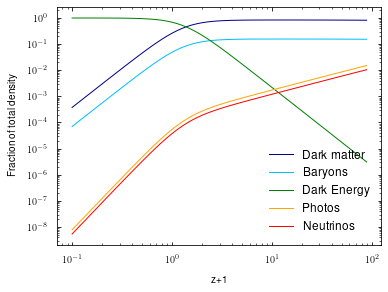

In [25]:
zp1 = 10**np.arange(-1.0, 2.0, 0.05)
z = zp1 - 1.0

O_b = cosmo.Ob(z)
O_dm = cosmo.Om(z) - O_b
O_de = cosmo.Ode(z)
O_gamma = cosmo.Ogamma(z)
O_nu = cosmo.Onu(z)

plt.figure()
plt.loglog()
plt.xlabel('z+1')
plt.ylabel('Fraction of total density')
plt.plot(zp1, O_dm, '-', label = 'Dark matter')
plt.plot(zp1, O_b, '-', label = 'Baryons')
plt.plot(zp1, O_de, '-', label = 'Dark Energy')
plt.plot(zp1, O_gamma, '-', label = 'Photos')
plt.plot(zp1, O_nu, '-', label = 'Neutrinos')
plt.legend(loc = 4);

There is more to the functions mentioned above: they can also give us their own inverse, e.g. $z(t)$ instead of $t(z)$:

In [17]:
z = np.array([0.0, 1.0, 2.0, 3.0])
t = cosmo.age(z)
z2 = cosmo.age(t, inverse = True)
print(z2)

[-4.34718719e-05  9.99787352e-01  1.99991496e+00  3.00002254e+00]


The slight errors in the recovered redshifts give a hint as to how colossus works internally: the majority of functions rely on interpolation for performance. The interpolating splines can be inverted numerically. If, for some reason, you really need the exact calculation, you can set `interpolation = False` in the constructor, or at a later time.

Once again using interpolating splines, we can also evaluate the derivatives of many functions, e.g. $dt/dz$ or $d^2t/dz^2$:

In [18]:
cosmo.age(z, derivative = 1)

array([-14.43560477,  -4.05678977,  -1.60037067,  -0.79726554])

In [19]:
cosmo.age(z, derivative = 2)

array([21.12575913,  4.41094814,  1.27172717,  0.48664907])

We can even combine the inverse and derivative arguments to evaluate the derivative of the inverse, e.g. $dz/dt$:

In [20]:
t = cosmo.age(z)
cosmo.age(t, inverse = True, derivative = 1)

array([-0.06928475, -0.24595949, -0.6259051 , -1.25408459])

A word of warning: while the documentation quotes a particular accuracy for each function, the accuracy of the derivatives and inverses is not guaranteed. There are many more functions related to densities, distances, and times. Please consult the [documentation of the cosmology module](https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html) for an exhaustive list.

## The distribution of matter: power spectrum, variance, correlation function

Colossus is geared toward calculations related to the evolution of structure in the universe and this focus is reflected in the cosmology module. We assume that the linear over- and underdensity field is given by a Gaussian random field which is unambiguously described by its power spectrum $P(k)$. By default, Colossus evaluates the matter power spectrum using the approximation of [Eisenstein & Hu 1998](http://adsabs.harvard.edu/abs/1998ApJ...496..605E), but the user can also pass a tabulated power spectrum (e.g., computed using CAMB). 

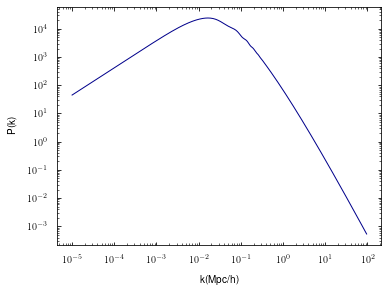

In [21]:
k = 10**np.arange(-5,2,0.02)
Pk = cosmo.matterPowerSpectrum(k)

plt.figure()
plt.loglog()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-');

It is a little hard to discern features in the power spectrum with this many orders of magnitude on the plot. As the functions discussed above, the `matterPowerSpectrum()` function relies on interpolating splines and can return the derivative of the power spectrum, highlighting the BAO wiggles:

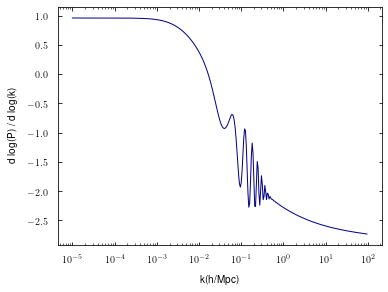

In [22]:
Pk_deriv = cosmo.matterPowerSpectrum(k, derivative = True)

plt.figure()
plt.xscale('log')
plt.xlabel('k(h/Mpc)')
plt.ylabel('d log(P) / d log(k)')
plt.plot(k, Pk_deriv, '-');

A number of important quantities are integrals over the power spectrum, for example the matter-matter correlation function:

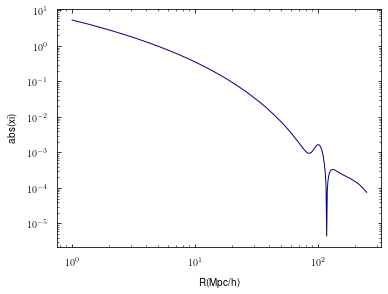

In [23]:
R = 10**np.arange(0,2.4,0.005)
xi = cosmo.correlationFunction(R, 0.0)

plt.figure()
plt.loglog()
plt.xlabel('R(Mpc/h)')
plt.ylabel('abs(xi)')
plt.plot(R, np.abs(xi), '-');

...or the variance `sigma(R)`. The variance is defined for a particular filter function, three of which are implemented in colossus: a top-hat in real space, a Gaussian, and a sharp-k space filter. The tophat filter is most commonly used, e.g. when computing peak height (see [LSS module](https://bdiemer.bitbucket.io/colossus/lss.html)), and is the default in Colossus.

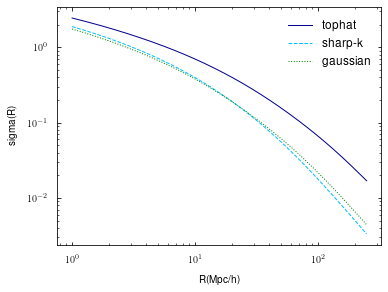

In [24]:
R = 10**np.arange(0,2.4,0.005)
sigma_tophat = cosmo.sigma(R, 0.0)
sigma_sharpk = cosmo.sigma(R, 0.0, filt = 'sharp-k')
sigma_gaussian = cosmo.sigma(R, 0.0, filt = 'gaussian')

plt.figure()
plt.loglog()
plt.xlabel('R(Mpc/h)')
plt.ylabel('sigma(R)')
plt.plot(R, sigma_tophat, '-', label = 'tophat')
plt.plot(R, sigma_sharpk, '--', label = 'sharp-k')
plt.plot(R, sigma_gaussian, ':', label = 'gaussian')
plt.legend();

You may notice that the first time you execute the functions the functions above, they can take up to a couple of seconds. That's because Colossus computes an interpolation table, saves it to disk, and loads it the next time the same cosmology is initiated. If, for some reason, this behavior is undesired, you can control it with the `interpolation` and `persistence` parameters to the constructor.